In [1]:
import os
import sys

# os.environ["CUDA_VISIBLE_DEVICES"] = "2"
sys.path.append("..")

In [2]:
%load_ext autoreload
%autoreload 2

import json

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torchmetrics
import torchvision.transforms.v2 as transforms
from IPython.display import clear_output
from monai.networks.nets import resnet10, resnet18
from skimage.io import imread, imsave
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

import transforms3d as T
from dataset3d import BNSet, BNSetMasks, get_dloader_mask, get_dloader_noise
from model3d import CNN3d
from util3d import get_obj_score3d, get_saliency3d, show_volume

sns.set_theme()

In [3]:
data_dir = "../data/bugNIST_DATA"
# data_dir = "/work3/s191510/data/BugNIST_DATA"
fig_dir = "../figures"

name_legend = {
    "ac": "brown_cricket",
    "bc": "black_cricket",
    "bf": "blow_fly",
    "bl": "buffalo_bettle_larva",
    "bp": "blow_fly_pupa",
    "cf": "curly-wing_fly",
    "gh": "grasshopper",
    "ma": "maggot",
    "ml": "mealworm",
    "pp": "green_bottle_fly_pupa",
    "sl": "soldier_fly_larva",
    "wo": "woodlice",
}


def get_model(model_type, device="cpu", seed=191510):
    torch.manual_seed(seed)
    if model_type == "r18":
        model = resnet18(
            spatial_dims=3,
            n_input_channels=1,
            no_max_pool=False,
            conv1_t_stride=2,
            num_classes=len(name_legend),
        )

    model.to(device)
    return model


device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Load models

In [4]:
model_dir = "../models/bn-checkpoints"
# run_dir = f"{model_dir}/run-20240524-053455"
run_dir = f"{model_dir}/run-20240523-012221"

with open(f"{run_dir}/config.json", "r") as f:
    config = json.load(f)
config

{'lr': 0.0001,
 'wd': 0.0,
 'batch_size': 32,
 'epochs': 200,
 'model_type': 'r18',
 'lr_step': 150,
 'perlin': True,
 'num_workers': 16,
 'save_every': 25,
 'wandb': True}

In [5]:
model = get_model("r18", device=device)
checkpoint = torch.load(f"{run_dir}/cpts/r18_e199.cpt")
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
del checkpoint

In [6]:
dloader = get_dloader_noise("test", 1, data_dir=data_dir)

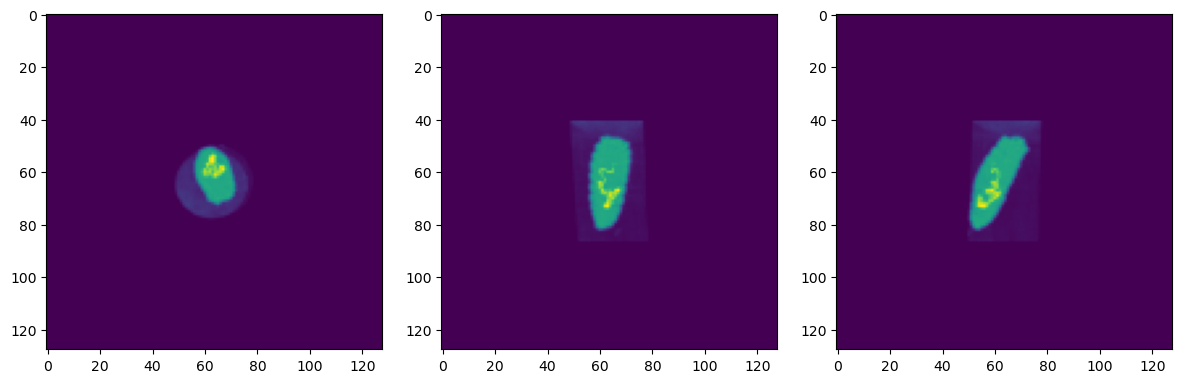

In [7]:
sns.reset_orig()
volume, label, mask, noise = next(iter(dloader))
show_volume(volume[0], size=4)

# Evaluate

In [8]:
perlin = config["perlin"]
perlin_in = True
suffix = f"_d{int(perlin)}e{int(perlin_in)}"

metrics = {
    "loss": [],
    "preds": [],
    "scores": [],
    "labels": [],
    "object_scores": [],
}

# Metrics
m_acc = torchmetrics.Accuracy("multiclass", num_classes=len(name_legend))
m_auc = torchmetrics.AUROC("multiclass", num_classes=len(name_legend))
m_prec = torchmetrics.Precision("multiclass", num_classes=len(name_legend))
m_rec = torchmetrics.Recall("multiclass", num_classes=len(name_legend))
m_f1 = torchmetrics.F1Score("multiclass", num_classes=len(name_legend))

criterion = nn.CrossEntropyLoss()

if perlin_in:
    get_input = lambda volumes, masks, noise: volumes * masks + ~masks * noise
else:
    get_input = lambda volumes, masks, noise: volumes * masks

for volumes, labels, masks, noise in tqdm(dloader):
    slc, score, indices, out = get_saliency3d(
        model, get_input(volumes, masks, noise), device=device
    )
    obj_score = get_obj_score3d(slc, masks)

    with torch.no_grad():
        loss = criterion(
            out.to(device), labels.type(torch.LongTensor).to(device)
        )

    _, indices = torch.max(out.cpu(), 1)

    metrics["loss"].append(loss.cpu().detach().item())
    metrics["preds"].append(indices.detach().numpy())
    metrics["scores"].append(out.softmax(dim=1).cpu().detach())
    metrics["labels"].append(labels.numpy())
    metrics["object_scores"].append(obj_score)

scores = torch.concatenate(metrics["scores"])
labels = torch.from_numpy(np.concatenate(metrics["labels"])).long()
labels_all = labels
performance = {
    "loss": np.mean(metrics["loss"]),
    "accuracy": m_acc(scores, labels).item(),
    "auroc": m_auc(scores, labels).item(),
    "precision": m_prec(scores, labels).item(),
    "recall": m_rec(scores, labels).item(),
    "f1score": m_f1(scores, labels).item(),
    "obj_score": np.mean(metrics["object_scores"]),
}

  0%|          | 0/1831 [00:00<?, ?it/s]

In [9]:
performance

{'loss': 0.12954984500573447,
 'accuracy': 0.9459311962127686,
 'auroc': 0.9976575970649719,
 'precision': 0.9459311962127686,
 'recall': 0.9459311962127686,
 'f1score': 0.9459311962127686,
 'obj_score': 0.9575214670656513}

In [10]:
with open(f'{run_dir}/test_performance{suffix}.json', 'w') as f:
    json.dump(performance, f, indent=6)

In [11]:
preds = scores.max(1)[1]
confmat = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=len(name_legend))
cmat = confmat(preds, labels).numpy()

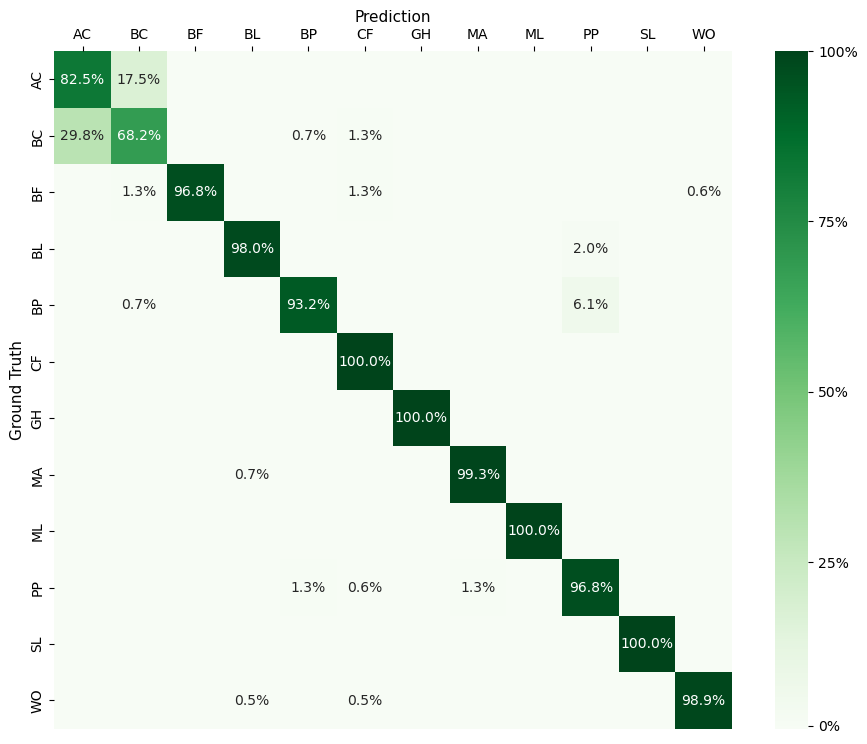

In [12]:
size = 11
cmat_norm = cmat / cmat.sum(1).reshape(-1, 1)
# cmat_norm[cmat == 0] = np.nan
fig, ax = plt.subplots(1, 1, figsize=(size, 4 * size/5))
ticks = list(map(lambda k: k.upper(), name_legend.keys()))
sns.heatmap(cmat_norm, mask=cmat==0, annot=True, fmt='.1%', cbar=True, square=True, cmap='Greens', xticklabels=ticks, yticklabels=ticks, ax=ax)
sns.heatmap(cmat_norm, mask=cmat!=0, annot=False, square=True, cbar=False, cmap='Greens', xticklabels=ticks, yticklabels=ticks, ax=ax)
cbar = ax.collections[0].colorbar
cbar.set_ticks([0.01, .25, .50, .75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.xaxis.tick_top()
ax.set_ylabel('Ground Truth', fontdict={'fontsize': size})
ax.set_xlabel('Prediction', fontdict={'fontsize': size})
ax.xaxis.set_label_position('top')
plt.savefig(f"{fig_dir}/bn_confmat{suffix}.pdf", bbox_inches='tight')
plt.show()

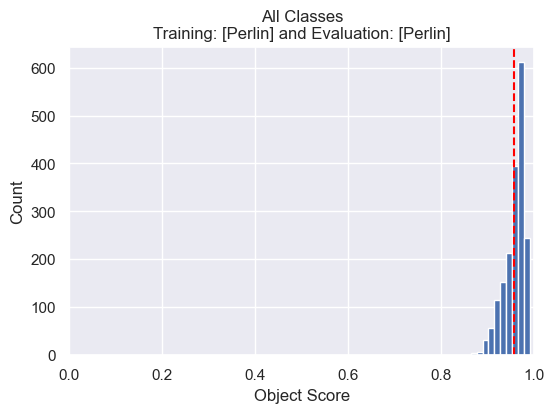

In [13]:
sns.set_theme()
if perlin:
    title = 'Training: [Perlin]'
else:
    title = 'Training: [Masked]'
if perlin_in:
    title += ' and Evaluation: [Perlin]'
else:
    title += ' and Evaluation: [Masked]'
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
obj_scores = np.array(metrics["object_scores"])
ax.hist(obj_scores, bins=10)
ax.axvline(obj_scores.mean(), ls="--", c="red")
ax.set_title(f'All Classes\n{title}')
ax.set_xlim(0, 1)
ax.set_xlabel('Object Score')
ax.set_ylabel('Count')
plt.savefig(f"{fig_dir}/bn_os_hist_all{suffix}.pdf", bbox_inches='tight')
plt.show()

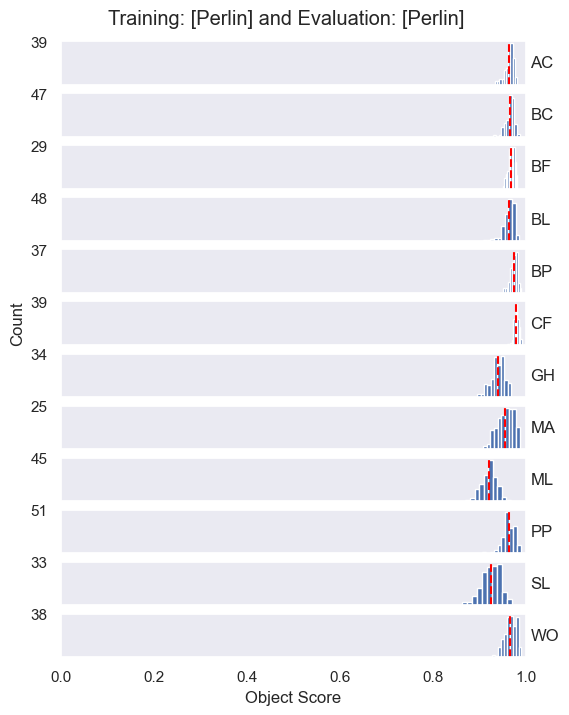

In [14]:
sns.set_theme()
fig, axs = plt.subplots(len(name_legend), 1, figsize=(6, 8), sharex=True)
for i in range(len(name_legend)):
    obj_scores_c = obj_scores[labels_all.numpy() == i]
    axs[i].hist(obj_scores_c)
    axs[i].axvline(obj_scores_c.mean(), ls="--", c="red")
    axs[i].set_title(list(map(lambda k: k.upper(), name_legend.keys()))[i], x=1.01, y=0.2, loc="left")
    axs[i].set_xlim(0, 1)
    axs[i].set_yticks([int(round(v)) for v in axs[i].get_ylim()[-1:]])
    axs[i].grid(False)
fig.suptitle(title, y=0.92)
axs[5].set_ylabel('Count')
axs[-1].set_xlabel('Object Score')
plt.savefig(f"{fig_dir}/bn_os_hist{suffix}.pdf", bbox_inches='tight')
plt.show()


# Saliency maps

In [15]:
slcs = {i: None for i in range(len(name_legend))}
count = 0
for volumes, labels, masks, noise in tqdm(dloader):
    c = labels.item()
    if slcs[c] is not None:
        continue
    volumes_in = get_input(volumes, masks, noise) 
    slc, score, indices, out = get_saliency3d(
            model, volumes_in, device=device
        )
    
    if slcs[c] is None:
        slcs[c] = masks * volumes_in + ~masks * volumes_in * 0.3, slc, score
        count += 1 
    if count == len(slcs):
        break

  0%|          | 0/1831 [00:00<?, ?it/s]

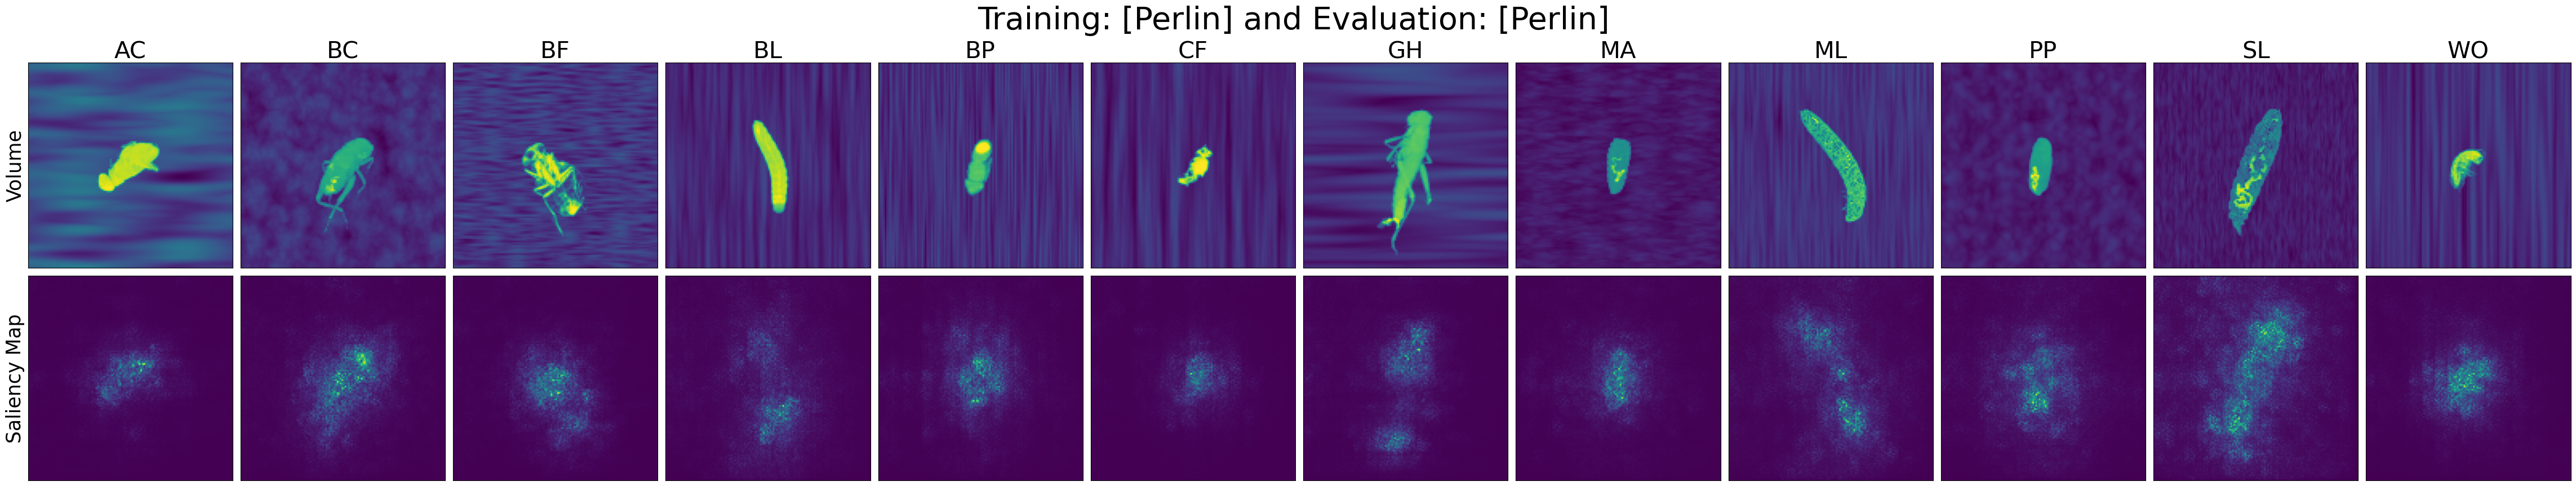

In [16]:
sns.reset_orig()

size = 4
fig, axs = plt.subplots(2, len(name_legend), figsize=(size * len(name_legend), size * 2), tight_layout=True, sharex=True, sharey=True)
fig.tight_layout(h_pad=0, w_pad=-size * 4)
c_to_key = lambda c: list(name_legend.keys())[c]
for c, (volume, slc, score) in slcs.items():
    volume = np.squeeze(volume.numpy())
    slc = np.squeeze(slc)
    name = c_to_key(c)
    axs[0][c].imshow(volume.max(1))
    axs[1][c].imshow(slc.max(1))
    axs[0][c].set_xticks([])
    axs[1][c].set_yticks([])
    axs[0][c].set_title(list(map(lambda k: k.upper(), name_legend.keys()))[c], fontdict={'fontsize': 30})
fig.suptitle(title, y=1.102, size=40)
axs[0][0].set_ylabel('Volume', fontdict={'fontsize': 25})
axs[1][0].set_ylabel('Saliency Map', fontdict={'fontsize': 25})
plt.savefig(f"{fig_dir}/bn_slc{suffix}.pdf", bbox_inches='tight')
plt.show()